# Convert the Radar Data Format to Row-Wise Format


In [1]:
import os
import sys
from pathlib import Path


def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


In [2]:
import pandas as pd
import numpy as np


## Read in the data


In [3]:
DATA_DIR = ROOT / "data" / "2023-01-13"

pwlf_data = pd.read_parquet(DATA_DIR / "pwlf_method.parquet")
headway_data = pd.read_parquet(DATA_DIR / "headway.parquet")
headway_data.set_index("veh", inplace=True)
headway_data = headway_data[headway_data["mean"] > 0.20]


vehicle_length_table = pd.read_parquet(DATA_DIR / "car_lengths.parquet")
# only keep lengths that are greater than 2m
vehicle_length_table = vehicle_length_table[vehicle_length_table["f32_length_m"] >= 2.0]


### Label the Operation Modes


In [4]:
cruise_thresh = 0.1

pwlf_data["type"] = np.where(pwlf_data["accel"] > cruise_thresh, "accel", "")
pwlf_data["type"] = np.where(
    pwlf_data["accel"] < -cruise_thresh, "decel", pwlf_data["type"]
)
pwlf_data["type"] = np.where(
    pwlf_data["accel"].abs() <= cruise_thresh, "cruise", pwlf_data["type"]
)


In [5]:
import itertools

accels = []
res = []
for r2, minium_time_in_state in itertools.product(
    np.linspace(0.75, 0.99, 10), np.linspace(0, 4, 10)
):
    base_filter = (pwlf_data["time_diff"] > minium_time_in_state) & (
        pwlf_data["r2"] > r2
    )

    # pwlf_data_accel = (
    #     pwlf_data[(pwlf_data["type"] == "accel") & base_filter]
    #     .groupby("vehicle_id")
    #     .apply(lambda x: np.average(x["accel"], weights=x["time_diff"]))
    # )
    # pwlf_data_decel = (
    #     pwlf_data[(pwlf_data["type"] == "decel") & base_filter]
    #     .groupby("vehicle_id")
    #     .apply(lambda x: np.average(x["accel"], weights=x["time_diff"]))
    # )

    res.append(
        (
            r2,
            minium_time_in_state,
            pwlf_data.loc[
                (pwlf_data["type"] == "accel") & base_filter, "accel"
            ].median(),
            pwlf_data.loc[
                (pwlf_data["type"] == "decel") & base_filter, "accel"
            ].median(),
            pwlf_data.loc[
                (pwlf_data["type"] == "accel") & base_filter, "vehicle_id"
            ].nunique(),
            pwlf_data.loc[
                (pwlf_data["type"] == "decel") & base_filter, "vehicle_id"
            ].nunique(),
            pwlf_data.loc[(pwlf_data["type"] == "accel") & base_filter, "accel"].shape[
                0
            ],
            pwlf_data.loc[(pwlf_data["type"] == "decel") & base_filter, "accel"].shape[
                0
            ],
        )
    )


df = pd.DataFrame(
    res,
    columns=[
        "r2",
        "min_time",
        "accel",
        "decel",
        "num_accel",
        "num_decel",
        "num_accel_pts",
        "num_decel_pts",
    ],
)


In [6]:
base_filter = (pwlf_data["time_diff"] > 1) & (pwlf_data["r2"] > 0.95)

(
    r2,
    minium_time_in_state,
    pwlf_data.loc[(pwlf_data["type"] == "accel") & base_filter, "accel"].median(),
    pwlf_data.loc[(pwlf_data["type"] == "decel") & base_filter, "accel"].median(),
    pwlf_data.loc[(pwlf_data["type"] == "accel") & base_filter, "vehicle_id"].nunique(),
    pwlf_data.loc[(pwlf_data["type"] == "decel") & base_filter, "vehicle_id"].nunique(),
    pwlf_data.loc[(pwlf_data["type"] == "accel") & base_filter, "accel"].shape[0],
    pwlf_data.loc[(pwlf_data["type"] == "decel") & base_filter, "accel"].shape[0],
)


(0.99, 4.0, 0.7711773634067327, -1.3689993294039857, 1135, 682, 1290, 1193)

Text(0.5, 0, 'Deceleration [$m/s^2$]')

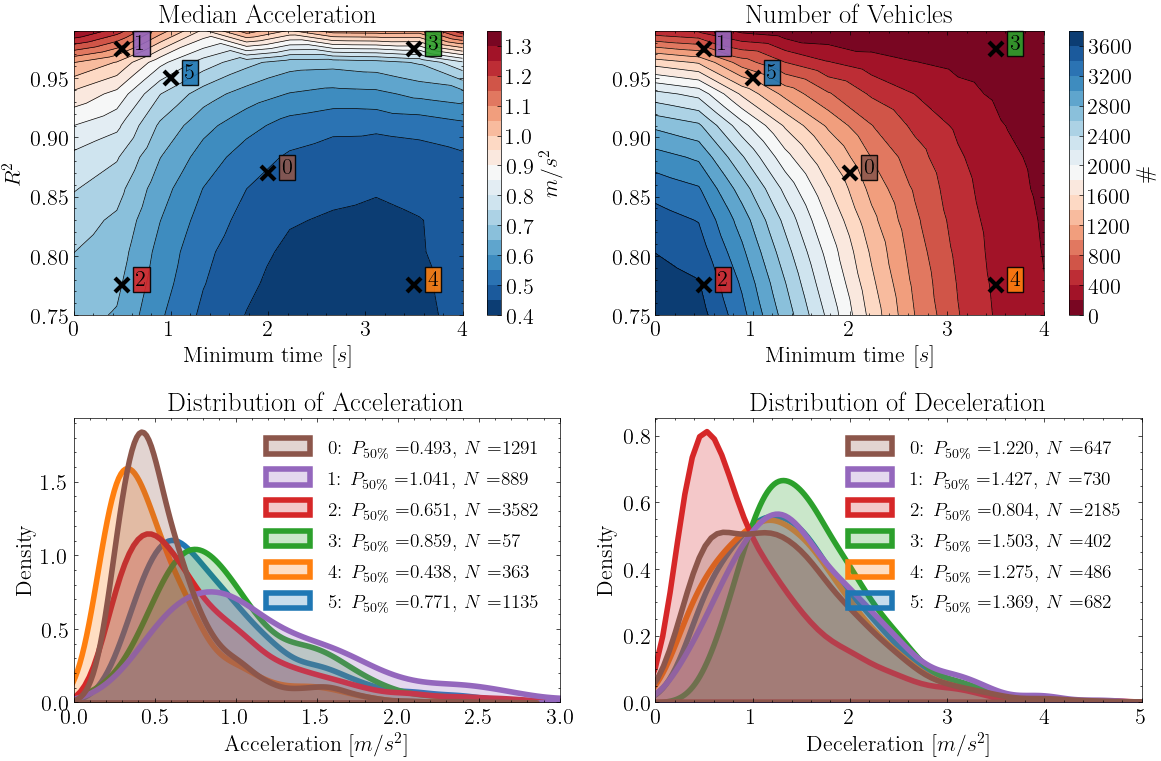

In [8]:
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("science")
# update the font size
plt.rcParams.update({"font.size": 16})
# create a color palette
palette = plt.get_cmap("tab10")
# create a map of colors for each group
color_map = {f"{i}": palette(5 - i) for i in range(6)}

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharey=False, tight_layout=True)

# plot locations
xys = [
    df[["min_time", "r2"]].values.mean(axis=0),
    [0.5, 0.975],
    [0.5, 0.775],
    [3.5, 0.975],
    [3.5, 0.775],
    [1, 0.95],
]


x = df["min_time"].values.tolist()
y = df["r2"].values.tolist()
z = df["accel"].values.tolist()
ax[0, 0].tricontour(x, y, z, levels=20, linewidths=0.5, colors="k")
cntr1 = ax[0, 0].tricontourf(x, y, z, levels=20, cmap="RdBu_r")
fig.colorbar(cntr1, ax=ax[0, 0], label="$m/s^2$")
ax[0, 0].set_title("Median Acceleration")
ax[0, 0].set_ylabel("$R^2$")
ax[0, 0].set_xlabel("Minimum time [$s$]")

# add an X to the mean
for i, (_x, _y) in enumerate(xys):
    for j in range(2):
        ax[0, j].plot(
            _x,
            _y,
            "x",
            color="black",
            markersize=10,
            markeredgewidth=3,
        )
        ax[0, j].annotate(
            f"{i}",
            (_x, _y),
            # add a white background to the text
            bbox=dict(facecolor=color_map[str(i)], edgecolor="black", pad=2, alpha=0.9),
            # move the text to the right
            xytext=(10, 0),
            textcoords="offset points",
        )


z = df["num_accel"].values.tolist()
ax[0, 1].tricontour(x, y, z, levels=20, linewidths=0.5, colors="k")
cntr1 = ax[0, 1].tricontourf(x, y, z, levels=20, cmap="RdBu")
# add a title to the colorbar
fig.colorbar(cntr1, ax=ax[0, 1], label="$\#$")
# add a colorbar title

ax[0, 1].set_title("Number of Vehicles")
ax[0, 1].set_xlabel("Minimum time [$s$]")

# add distributions to 1, 0
for j, type_ in enumerate(["accel", "decel"]):
    dists = []
    num_unique = {}
    for i, (_x, _y) in enumerate(xys):
        base_filter = (pwlf_data["time_diff"] > _x) & (pwlf_data["r2"] > _y)

        _df = pd.DataFrame(
            # pwlf_data[(pwlf_data["type"] == type_) & base_filter].groupby("vehicle_id").apply(lambda x: np.average(x["accel"], weights=x["time_diff"])).values,
            pwlf_data.loc[(pwlf_data["type"] == type_) & base_filter, "accel"]
            .abs()
            .values,
            columns=[type_],
        )
        _df["sample_pair"] = f"{i}"
        dists.append(_df)
        num_unique[str(i)] = pwlf_data[
            (pwlf_data["type"] == type_) & base_filter
        ].vehicle_id.nunique()

    dist_df = pd.concat(dists)
    sns.kdeplot(
        data=dist_df,
        x=type_,
        ax=ax[1, j],
        hue="sample_pair",
        palette=color_map,
        # set the linewidth to 4
        linewidth=4,
        # set the fill to true
        fill=True,
        # set mode to probability density
        common_norm=False,
    )

    # # remove the legend title
    ax[1, j].legend_.set_title(None)
    # set the background color of the legend
    ax[1, j].legend_.get_frame().set_facecolor("white")

    # move the legend to the right
    if j > 0:
        sns.move_legend(ax[1, j], "upper right")

    for t in ax[1, j].legend_.texts:
        l = t.get_text()
        t.set_text(
            f"{l}"
            + ": $P_{50\%} = $"
            + f"{dist_df.loc[dist_df['sample_pair'] == l, type_].median():.3f}, $N = ${num_unique[l]}"
        )
        # set the text size
        t.set_fontsize(14)

ax[1, 0].set_xlim(0, 3)
ax[1, 0].set_title("Distribution of Acceleration")
ax[1, 0].set_xlabel("Acceleration [$m/s^2$]")

ax[1, 1].set_xlim(0, 5)
ax[1, 1].set_title("Distribution of Deceleration")
ax[1, 1].set_xlabel("Deceleration [$m/s^2$]")


In [8]:
minium_time_in_state = 1
r2 = 0.95

base_filter = (pwlf_data["time_diff"] > minium_time_in_state) & (pwlf_data["r2"] > r2)
pwlf_data_accel = (
    pwlf_data[(pwlf_data["type"] == "accel") & base_filter]
    .groupby("vehicle_id")
    .apply(lambda x: np.average(x["accel"], weights=x["time_diff"]))
)
pwlf_data_decel = (
    pwlf_data[(pwlf_data["type"] == "decel") & base_filter]
    .groupby("vehicle_id")
    .apply(lambda x: np.average(x["accel"], weights=x["time_diff"]))
)

minium_time_in_state = 0.1
pwlf_data_cruise = (
    pwlf_data[
        (pwlf_data["type"] == "cruise")
        & (pwlf_data["time_diff"] > minium_time_in_state)
    ]
    .groupby("vehicle_id")
    .apply(lambda x: np.average(x["speed"], weights=x["time_diff"]))
)


### Plotting


In [9]:
def hist_ecdf(*plots, ax, colors, limits):
    for i, plot_series in enumerate(plots):
        ax.hist(
            plot_series[1],
            bins=100,
            label=plot_series[0],
            alpha=0.5,
            density=True,
            color=colors[i],
        )

        # create a ecdf of the acceleration values on the right y-axis
        ax2 = ax.twinx()
        ax2.scatter(
            np.sort(plot_series[1].values),
            np.linspace(0, 1, len(plot_series[1].values)),
            label=plot_series[0],
            alpha=1,
            s=1,
            color=colors[i],
        )

    # set x-axis limits
    ax.set_xlim(*limits)


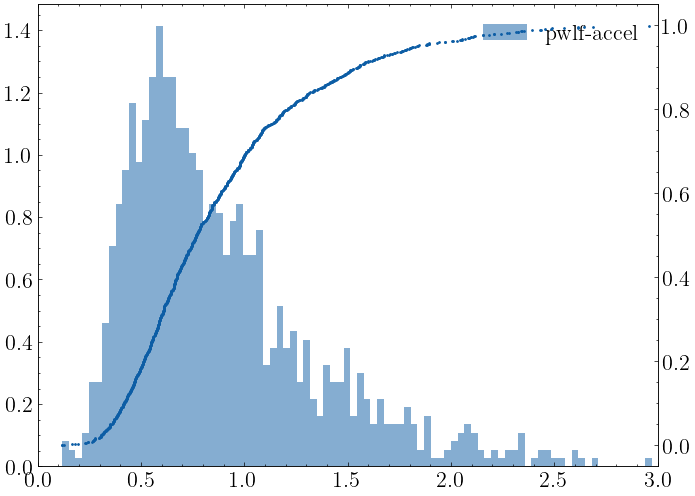

In [10]:
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("science")
plt.rcParams.update({"font.size": 16})

# create a color palette
palette = colors = sns.color_palette("Paired", 8, desat=0.8)
# get every other color
colors = [palette[i] for i in range(0, len(palette), 2)]

# plot pwlf accel vs decel
fig, ax = plt.subplots(figsize=(8, 6))
hist_ecdf(
    ("pwlf-accel", pwlf_data_accel),
    ax=ax,
    colors=["C0", "C1"],
    limits=(0, 3),
)

ax.legend()


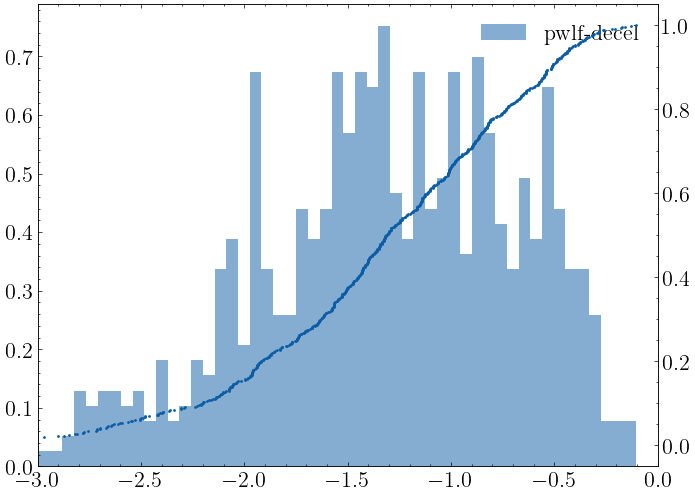

In [11]:
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("science")
plt.rcParams.update({"font.size": 16})

# create a color palette
palette = colors = sns.color_palette("Paired", 8, desat=0.8)
# get every other color
colors = [palette[i] for i in range(0, len(palette), 2)]

# plot pwlf accel vs decel
fig, ax = plt.subplots(figsize=(8, 6))
hist_ecdf(
    ("pwlf-decel", pwlf_data_decel),
    ax=ax,
    colors=["C0", "C1"],
    limits=(-3, 0),
)

ax.legend()


### Additional Cruise Filtering


In [12]:
# do the same for pwlf
filter_ = pwlf_data_cruise.index.isin(headway_data[headway_data["mean"] > 5].index) & (
    pwlf_data.loc[pwlf_data.vehicle_id.isin(pwlf_data_cruise.index)]
    .groupby("vehicle_id")["accel"]
    .max()
    .loc[pwlf_data_cruise.index]
    .abs()
    < 1
)
pwlf_data_cruise_new = pwlf_data_cruise[filter_]


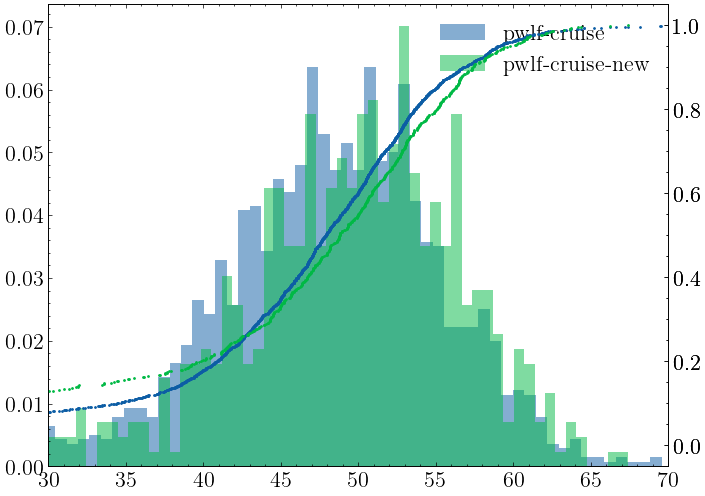

In [13]:
# plot pwlf accel vs decel
fig, ax = plt.subplots(figsize=(8, 6))
hist_ecdf(
    ("pwlf-cruise", pwlf_data_cruise * 2.23694),
    ("pwlf-cruise-new", pwlf_data_cruise_new * 2.23694),
    ax=ax,
    colors=["C0", "C1", "C2", "C3"],
    limits=(30, 70),
)

ax.legend()


In [14]:
# create the speed factors
speed_limit = 22.35

# create the speed factors
pwlf_data_cruise_new = pwlf_data_cruise_new / speed_limit

# filter out low end. Nothing slower than 35 mph
filter_ = pwlf_data_cruise_new > (35 / (speed_limit * 2.23694))
pwlf_data_cruise_new = pwlf_data_cruise_new[filter_]


### Checking the acceleration of Vehicles not in Car Following


In [21]:
minium_time_in_state = 1
r2 = 0.95

no_car_following = headway_data[headway_data["mean"] > 5].index
car_following = headway_data[headway_data["mean"] < 5].index


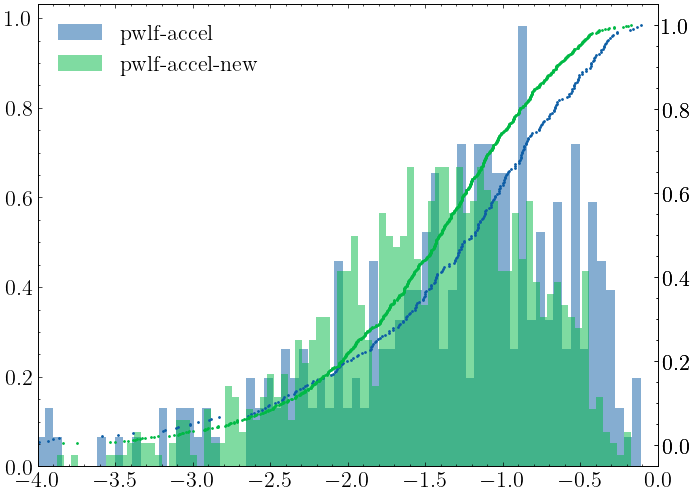

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
plt_data = pwlf_data.loc[
    pwlf_data.vehicle_id.isin(no_car_following)
    & (pwlf_data.time_diff > minium_time_in_state)
    & (pwlf_data.r2 > r2) & (pwlf_data.type == "decel"),
    "accel",
]

plt_data_cf = pwlf_data.loc[
    pwlf_data.vehicle_id.isin(car_following)
    & (pwlf_data.time_diff > minium_time_in_state)
    & (pwlf_data.r2 > r2) & (pwlf_data.type == "decel"),
    "accel",
]

hist_ecdf(
    ("pwlf-accel", plt_data_cf),
    ("pwlf-accel-new", plt_data),
    ax=ax,
    colors=["C0", "C1"],
    limits=(-4, 0),
)

ax.legend()


In [ ]:
from scipy.stats import mannwhitneyu


mannwhitneyu(pwlf_data_decel, plt_data)

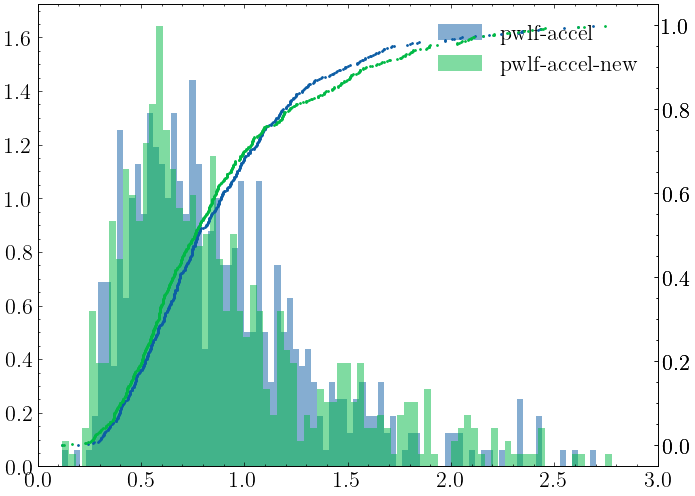

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
plt_data = pwlf_data.loc[
    pwlf_data.vehicle_id.isin(no_car_following)
    & (pwlf_data.time_diff > minium_time_in_state)
    & (pwlf_data.r2 > r2) & (pwlf_data.type == "accel"),
    "accel",
]

plt_data_cf = pwlf_data.loc[
    pwlf_data.vehicle_id.isin(car_following)
    & (pwlf_data.time_diff > minium_time_in_state)
    & (pwlf_data.r2 > r2) & (pwlf_data.type == "accel"),
    "accel",
]

hist_ecdf(
    ("pwlf-accel", plt_data_cf),
    ("pwlf-accel-new", plt_data),
    ax=ax,
    colors=["C0", "C1"],
    limits=(0, 3),
)

ax.legend()


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt_data = pwlf_data.loc[
    pwlf_data.vehicle_id.isin(no_car_following)
    & (pwlf_data.time_diff > minium_time_in_state)
    & (pwlf_data.r2 > r2)
    & (pwlf_data.type == "accel"),
    "accel",
]

plt_accel = pwlf_data.loc[
    (pwlf_data.time_diff > minium_time_in_state)
    & (pwlf_data.r2 > r2)
    & (pwlf_data.type == "accel"),
    "accel",
]


hist_ecdf(
    ("pwlf-accel", plt_accel),
    ("pwlf-accel-new", plt_data),
    ax=ax,
    colors=["C0", "C1"],
    limits=(0, 3),
)

ax.legend()


In [58]:
from scipy.stats import mannwhitneyu


mannwhitneyu(plt_accel, plt_data)

MannwhitneyuResult(statistic=421152.5, pvalue=0.43457667167320324)

### Create a DataFrame for SUMO


In [18]:
minium_time_in_state = 1
r2 = 0.95
samples = 1000


In [19]:
# only keep headway data where the vehicle has headway < 5
merge_headway = headway_data[headway_data["mean"] < 5]


In [20]:
merge_headway.shape


(1831, 1)

In [21]:
# # make a no cf independent sample
# no_car_following = headway_data[headway_data["mean"] > 5].index
# pwlf_data_no_cf = pwlf_data.loc[
#     pwlf_data.vehicle_id.isin(no_car_following)
#     & (pwlf_data.time_diff > minium_time_in_state)
#     & (pwlf_data.r2 > r2)
#     & pwlf_data.type.isin(['accel', 'decel'])
# ]

# uncor_pwlf_df_no_cf = pd.DataFrame(
#     {
#         "accel": np.random.choice(pwlf_data_no_cf.loc[pwlf_data_no_cf.type == "accel", 'accel'], samples),
#         "decel": np.random.choice(pwlf_data_no_cf.loc[pwlf_data_no_cf.type == "decel", 'accel'], samples),
#         "tau": np.random.choice(merge_headway["mean"], samples),
#         "length": np.random.choice(vehicle_length_table["f32_length_m"], samples),
#     }
# )


In [22]:
print(pwlf_data_accel.shape, pwlf_data_decel.shape)
pwlf_df = pwlf_data_accel.to_frame("accel").merge(
    pwlf_data_decel.to_frame("decel"), left_index=True, right_index=True, how="inner"
)
print(pwlf_df.shape)
corr_pwlf_df = pwlf_df.merge(
    merge_headway.rename({"mean": "tau"}, axis=1),
    left_index=True,
    right_index=True,
    how="inner",
)
print(corr_pwlf_df.shape)
corr_pwlf_df["decel"] = corr_pwlf_df["decel"] * -1
corr_pwlf_df = (
    corr_pwlf_df.merge(
        vehicle_length_table, left_index=True, right_on="ui32_objectID", how="inner"
    )
    .rename({"f32_length_m": "length"}, axis=1)
    .drop(["ui32_objectID"], axis=1)
)
print(corr_pwlf_df.shape)
corr_pwlf_df["speedFactor"] = np.random.choice(
    pwlf_data_cruise_new, size=corr_pwlf_df.shape[0]
)


(1135,) (682,)
(165, 2)
(48, 3)
(48, 4)


In [23]:
# create an product sample
minium_time_in_state = 1
r2 = 0.95


pwlf_data_keep = pwlf_data.loc[
    (pwlf_data.time_diff > minium_time_in_state)
    & (pwlf_data.r2 > r2)
    & pwlf_data.type.isin(["accel", "decel"])
]

print(pwlf_data_keep.shape)
# keep vehicles that have both accel and decel
pwlf_data_keep = pwlf_data_keep.groupby("vehicle_id").filter(
    lambda x: x.type.nunique() == 2
)
print(pwlf_data_keep.vehicle_id.nunique())

res = []
for v_id, v_df in pwlf_data_keep.groupby("vehicle_id"):
    accels = v_df[v_df.type == "accel"].accel.values
    decels = v_df[v_df.type == "decel"].accel.values
    for accel in accels:
        res.extend(
            {"vehicle_id": v_id, "accel": accel, "decel": decel} for decel in decels
        )
# create a dataframe
pwlf_df_product = pd.DataFrame(res)

print(pwlf_df_product.shape)
# merge with headway
pwlf_df_product = pwlf_df_product.merge(
    merge_headway.rename({"mean": "tau"}, axis=1),
    left_on="vehicle_id",
    right_index=True,
)

# merge with vehicle length
pwlf_df_product = (
    pwlf_df_product.merge(
        vehicle_length_table,
        left_on="vehicle_id",
        right_on="ui32_objectID",
        how="inner",
    )
    .rename({"f32_length_m": "length"}, axis=1)
    .drop(["ui32_objectID"], axis=1)
)

# add in the speed factor
print(pwlf_df_product.vehicle_id.nunique(), pwlf_df_product.shape)
pwlf_df_product["speedFactor"] = np.random.choice(
    pwlf_data_cruise_new, size=pwlf_df_product.shape[0]
)


(2483, 9)
165
(290, 3)
48 (82, 5)


In [24]:
pwlf_df_product


,vehicle_id,accel,decel,tau,length,speedFactor
0,35817,1.425515,-1.560571,3.480033,5.042850,0.974840
1,35817,1.425515,-2.346434,3.480033,5.042850,1.070667
2,36157,1.599247,-0.716500,3.760604,3.998712,1.105996
3,36157,1.599247,-1.180210,3.760604,3.998712,0.841384
4,36157,1.599247,-1.303090,3.760604,3.998712,1.205350
...,...,...,...,...,...,...
77,63263,1.713051,-1.734742,2.763774,3.702839,1.002184
78,63859,0.675014,-0.617482,1.282997,4.356503,1.079403
79,64119,2.337169,-1.394394,4.534050,4.294028,1.088136
80,64119,2.337169,-1.110688,4.534050,4.294028,1.149432


In [25]:
samples = 10000

np.random.seed(42)

# create a random sample of the data
uncor_pwlf_df = pd.DataFrame(
    {
        "accel": np.random.choice(pwlf_data_accel, samples),
        "decel": np.random.choice(pwlf_data_decel, samples),
        "tau": np.random.choice(merge_headway["mean"], samples),
        "length": np.random.choice(vehicle_length_table["f32_length_m"], samples),
        "speedFactor": np.random.choice(pwlf_data_cruise_new, samples),
    }
)


In [26]:
minium_time_in_state = 1
r2 = 0.95

# create the no-car following data
no_car_following = headway_data[headway_data["mean"] > 5].index

# filter out the data
pwlf_data_keep = pwlf_data.loc[
    pwlf_data.vehicle_id.isin(no_car_following)
    & (pwlf_data.time_diff > minium_time_in_state)
    & (pwlf_data.r2 > r2)
    & pwlf_data.type.isin(["accel", "decel"])
]

# keep vehicles that have both accel and decel
pwlf_data_keep = pwlf_data_keep.groupby("vehicle_id").filter(
    lambda x: x.type.nunique() == 2
)

res = []
for v_id, v_df in pwlf_data_keep.groupby("vehicle_id"):
    accels = v_df[v_df.type == "accel"].accel.values
    decels = v_df[v_df.type == "decel"].accel.values
    for accel in accels:
        res.extend(
            {"vehicle_id": v_id, "accel": accel, "decel": decel} for decel in decels
        )
# create a dataframe
pwlf_df_product_no_cf = pd.DataFrame(res)

# Can't merge with headway data because there is no headway data
pwlf_df_product_no_cf["tau"] = np.random.choice(
    merge_headway["mean"], pwlf_df_product_no_cf.shape[0]
)


pwlf_df_product_no_cf["speedFactor"] = np.random.choice(
    pwlf_data_cruise_new, size=pwlf_df_product_no_cf.shape[0]
)


print(pwlf_df_product_no_cf.shape)


(193, 5)


In [29]:
from scipy.stats import mannwhitneyu


In [30]:
mannwhitneyu(uncor_pwlf_df["accel"].values, pwlf_df_product["accel"].values)


MannwhitneyuResult(statistic=218909.5, pvalue=3.34001801113592e-13)

Uncorrelated accel mean: 0.77, std: 0.48
Correlated accel mean: 1.28, std: 0.57
MannwhitneyuResult(statistic=218909.5, pvalue=3.34001801113592e-13)
Uncorrelated decel mean: -1.32, std: 0.71
Correlated decel mean: -1.13, std: 0.64
MannwhitneyuResult(statistic=342910.5, pvalue=0.010591922981345306)
Uncorrelated tau mean: 2.65, std: 1.22
Correlated tau mean: 3.07, std: 1.07
MannwhitneyuResult(statistic=335947.0, pvalue=0.004784943711176915)


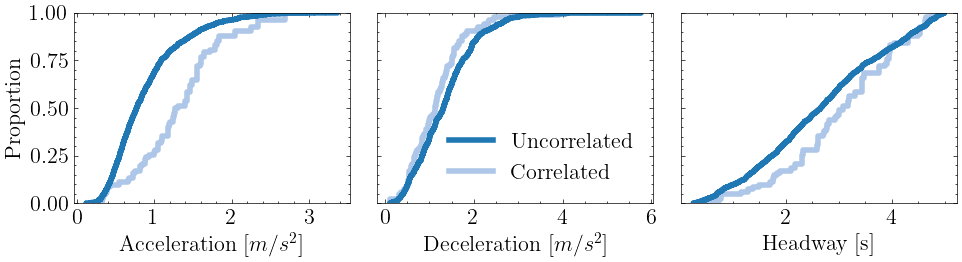

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True, tight_layout=True)
# set the font size
plt.rcParams.update({"font.size": 16})

palette = plt.get_cmap("tab20")
color_map = {"Uncorrelated": palette(0), "Correlated": palette(1)}

for i, (type_, label) in enumerate(
    [
        ("accel", "Acceleration [$m/s^2$]"),
        ("decel", "Deceleration [$m/s^2$]"),
        ("tau", "Headway [s]"),
    ]
):
    print(
        f"Uncorrelated {type_} mean: {uncor_pwlf_df[type_].median():.2f}, std: {uncor_pwlf_df[type_].std():.2f}"
    )
    print(
        f"Correlated {type_} mean: {pwlf_df_product[type_].median():.2f}, std: {pwlf_df_product[type_].std():.2f}"
    )
    print(mannwhitneyu(uncor_pwlf_df[type_].values, pwlf_df_product[type_].values))
    sns.ecdfplot(
        pd.DataFrame(
            data=[
                uncor_pwlf_df[type_].abs().values,
                pwlf_df_product[type_].abs().values,
            ],
            index=[
                "Uncorrelated",
                "Correlated",
            ],
        ).T,
        ax=ax[i],
        palette=color_map,
        # set the width of the lines
        linewidth=4,
        # only show the legend on the first plot
        legend=i == 1,
    )

    ax[i].set_xlabel(label)


<AxesSubplot: ylabel='Proportion'>

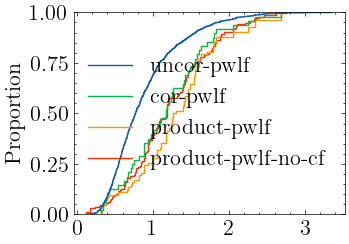

In [28]:
# create a dataframe with all the accel

sns.ecdfplot(
    pd.DataFrame(
        data=[
            uncor_pwlf_df["accel"].values,
            corr_pwlf_df["accel"].values,
            pwlf_df_product["accel"].values,
            # pwlf_df_product_no_cf['accel'].values,
            # uncor_pwlf_df_no_cf['accel'].values,
        ],
        index=[
            "uncor-pwlf",
            "cor-pwlf",
            "product-pwlf",
            # "product-pwlf-no-cf",
            # "uncor-pwlf-no-cf",
        ],
    ).T
)


<AxesSubplot: ylabel='Proportion'>

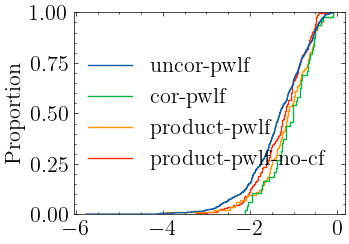

In [25]:
# create a dataframe with all the accel

sns.ecdfplot(
    pd.DataFrame(
        data=[
            uncor_pwlf_df["decel"].values,
            corr_pwlf_df["decel"].values * -1,
            pwlf_df_product["decel"].values,
            pwlf_df_product_no_cf["decel"].values,
        ],
        index=["uncor-pwlf", "cor-pwlf", "product-pwlf", "product-pwlf-no-cf"],
    ).T
)


<AxesSubplot: ylabel='Proportion'>

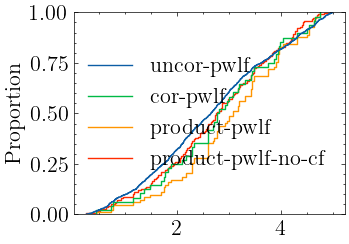

In [26]:
# create a dataframe with all the accel

sns.ecdfplot(
    pd.DataFrame(
        data=[
            uncor_pwlf_df["tau"].values,
            corr_pwlf_df["tau"].values,
            pwlf_df_product["tau"].values,
            pwlf_df_product_no_cf["tau"].values,
        ],
        index=["uncor-pwlf", "cor-pwlf", "product-pwlf", "product-pwlf-no-cf"],
    ).T
)


In [27]:
import corner
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

# make the text bigger
plt.rcParams.update({"font.size": 16})


In [28]:
# fig = corner.corner(
#     pwlf_df_product[["accel", "decel", "tau"]],  # [['accel', 'decel']],
#     labels=["Accel [$m/s^2$]", "Decel [$m/s^2$]", "Headway [s]"],
#     quantiles=(0.1, 0.9),
#     show_titles=True,
#     title_kwargs={"fontsize": 15},
#     plot_countours=False,
# )


### Save the data


In [29]:
def save_df_to_csv(df, filename):
    df["vClass"] = "passenger"
    # this is dumb for now, but it works
    df["emissionClass"] = df["vClass"].map(
        {"passenger": "PHEMlight/PC_G_EU4", "trailer": "PHEMlight/HDV_TT_D_EU6"}
    )

    df["decel"] = df["decel"].abs()

    df.to_csv(filename, index=False)


In [30]:
save_df_to_csv(
    uncor_pwlf_df,
    "/Users/max/Development/sumo-uc-2023/data/2023-01-13/processed/uncor_pwlf.csv",
)
save_df_to_csv(
    corr_pwlf_df,
    "/Users/max/Development/sumo-uc-2023/data/2023-01-13/processed/corr_lowess.csv",
)
save_df_to_csv(
    pwlf_df_product.drop("vehicle_id", axis=1),
    "/Users/max/Development/sumo-uc-2023/data/2023-01-13/processed/corr_pwlf_product.csv",
)


## Plotting


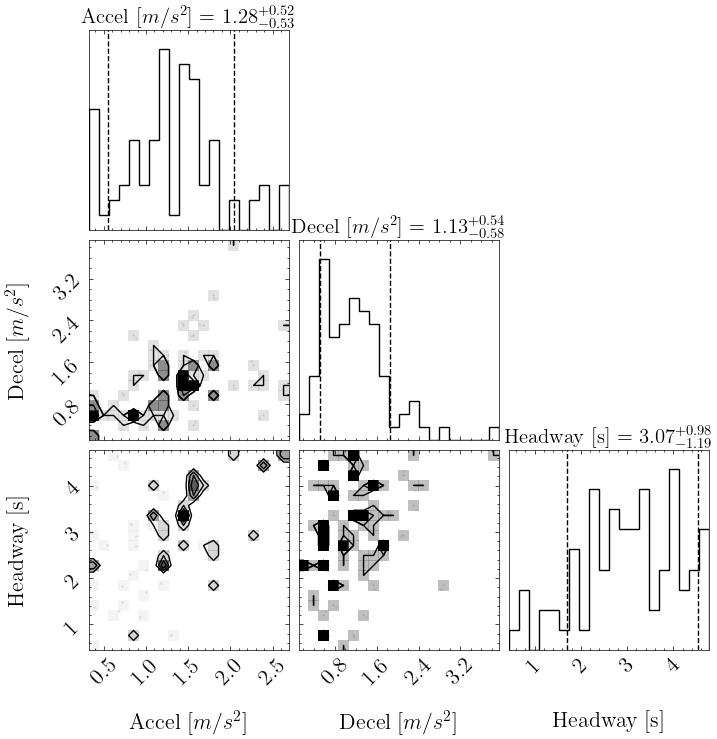

In [61]:
fig = corner.corner(
    pwlf_df_product[["accel", "decel", "tau"]],  # [['accel', 'decel']],
    labels=["Accel [$m/s^2$]", "Decel [$m/s^2$]", "Headway [s]"],
    quantiles=(0.1, 0.9),
    show_titles=True,
    title_kwargs={"fontsize": 15},
)


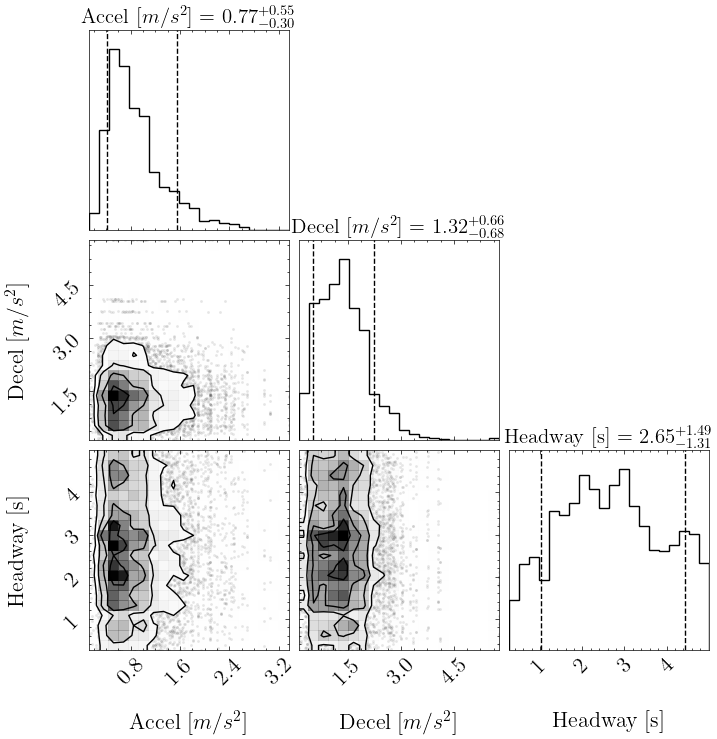

In [62]:
fig = corner.corner(
    uncor_pwlf_df[["accel", "decel", "tau"]],  # [['accel', 'decel']],
    labels=["Accel [$m/s^2$]", "Decel [$m/s^2$]", "Headway [s]"],
    quantiles=(0.1, 0.9),
    show_titles=True,
    title_kwargs={"fontsize": 15},
)
